# Compute dew point for wide range of temperatures and humidities
A key issue with reusing the existing ductwork for a heat pump is whether the ducts will sweat during the summer when the heat pump is in operation. In particular, the ducts date from the 1940's and are uninsulated sheet metal and some thin MDF panels were probably added more recently. So, the goal here is to find the "safe" range of temperatures __in duct__ so that even on hot and humid days, we won't get condensation on the outside walls of our ducts and then mold issues in the wall. If the system can be sized so that it says within this safe range, then we have less work to do with renovating our ducts. Ideally a smaller, lower speed system can gradually "take the edge off" the summer heat instead of working really hard to very quickly over cool the house. This is only an issue for the summer cooling season and does not apply to the winter heating season.

Some background in [this blog post](https://www.greenbuildingadvisor.com/article/why-air-conditioning-vents-sweat) including the rule of thumb that air off the AC coil is about 55-60 deg F and the fact that increasing air flow can help reduce vent/duct sweating. Additional [explanations of air flow relative to AC capacity](https://www.greenbuildingadvisor.com/article/getting-the-right-airflow-for-an-air-conditioning-system) are really interesting and [static pressure drop scales with velocity squared](https://www.greenbuildingadvisor.com/article/the-best-velocity-for-moving-air-through-ducts-part-1). This [ductalator](https://www.h2xengineering.com/ductulator/) seems to help set the balance between duct size, pressure drop, and air speed. My guess is that the balance above is how the design sizing is set in [this table](https://skyheating.com/wp-content/uploads/2021/09/Sky-Heating-Ductwork-Sizing-Guide.pdf).

It looks like the design process is something like this:
1. Figure out the heating and cooling loads (i.e. Manual J). We are going to be about 25,000 BTUh gain (summer) and 39,000 BTUh loss (winter) for "normal" interior temperatures.
2. Overall system sizing is based on 1 ton = 12,000 BTU per hour. Based on the above, we're about 2 tons cooling and 3 tons heating.
3. For the summer (humidity), we're looking at 300 CFM/ton and the winter its 500 CFM/ton over the coil. These translate to 600 CFM (summer) and 1500 CFM (winter).
4. Can our ductwork sustain that without too much of a pressure drop?

In [ ]:
#! git clone https://github.com/Unidata/MetPy ../MetPy

In [ ]:
#! cd ../MetPy; pip install .

In [ ]:
#! pip install metpy==1.2
! conda install -y -c conda-forge metpy

In [1]:
# Example MetPy calculation from
# https://unidata.github.io/MetPy/latest/userguide/startingguide.html#calculations
import numpy as np
from metpy.units import units
import metpy.calc as mpcalc
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Single checkpoint
temperature = [41.5] * units.degC
rel_humidity  = [76] * units.percent
print(mpcalc.dewpoint_from_relative_humidity(temperature, rel_humidity))

[36.41169876894935] degree_Celsius


In [3]:
# Convert F to C
F = 15
C = (F-32)*(5/9)
print(C)


-9.444444444444445


In [4]:
# Compute dewpoint (d) over a wide range of temperatures (t) and humidities (q)

# Min expected temp over whole year
#t_min = -30.0

# Min temp at which we would consider running the heat pump in cooling mode
t_min = -10.0
t_max = 40.0

# Min possible humidity
q_min = 0.0

# Min realistic humidity
q_min = 20.0
q_max = 100.0

# Have two different numbers of points on the axis for fine
# tuning and cross checking I get the orientations right.
n_t_pts = 131
n_q_pts = 101

t_axis = np.linspace(t_min, t_max, num=n_t_pts)
q_axis = np.linspace(q_min, q_max, num=n_q_pts)

[q_mesh, t_mesh] = np.meshgrid(q_axis,t_axis)

t_mesh_w_units = t_mesh * units.degC
q_mesh_w_units = q_mesh * units.percent

t_mesh_w_units_degF = t_mesh_w_units.to(units.degF)

d_mesh_w_units_degC = mpcalc.dewpoint_from_relative_humidity(t_mesh_w_units, q_mesh_w_units)
d_mesh_w_units_degF = d_mesh_w_units_degC.to(units.degF)

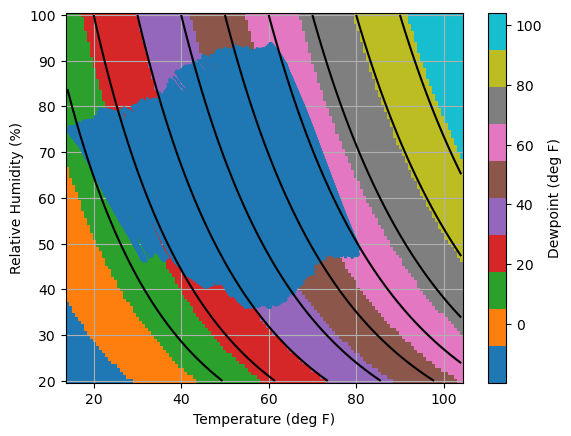

In [6]:
cmap = plt.get_cmap('tab10')
fig, ax = plt.subplots()

levels=[10, 20, 30, 40, 50, 60, 70, 80, 90]

# Simple dewpoint
im = ax.pcolormesh(t_mesh_w_units_degF, q_mesh_w_units, d_mesh_w_units_degF, shading='auto',cmap=cmap)

# Difference between ambient temp and dewpoint (ambient temp is always higher)
#im = ax.pcolormesh(t_mesh, q_mesh, t_mesh_w_units - d_mesh_w_units, shading='auto',cmap=cmap)

# To run this line, first run the cell with local data below
ax.plot(t_degF, q)

# Put contour lines OVER the observations
plt.contour(t_mesh_w_units_degF, q_mesh_w_units, d_mesh_w_units_degF, levels, colors='k')

ax.set(xlabel='Temperature (deg F)',ylabel='Relative Humidity (%)')
fig.colorbar(im, ax=ax, label="Dewpoint (deg F)")
ax.grid()

We want to keep the dewpoint [below 65 deg F = ~18 deg C for comfort](https://www.weather.gov/arx/why_dewpoint_vs_humidity).
We also want the air in the ducts to be above the dewpoint. So let's consider some cases:
+ 95 degree day - at about 30% RH, it becomes ~60 deg C dewpoint - we will want the air in the ducts above ~70 deg C. 
+ 95 degree day - at about 90% RH, it becomes 90 deg C dewpoint. Is that even possible?

Let's get some [historical data from KCON airport](https://www.ncdc.noaa.gov/cdo-web/search) - I selected 'Normals Hourly' and could only get 2010 data. The monthly data spans a longer time range but does not include humidity data.

The temperature range in the 2010 data is consistent with [climatologies from weatherspark](https://weatherspark.com/countries/US/NH).

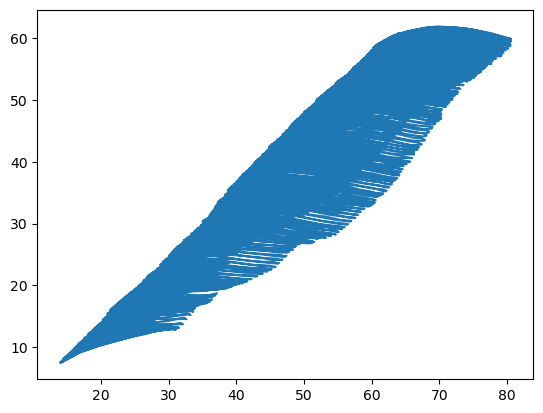

In [5]:
t_and_q_df = pd.read_csv('3852803.csv')

# Need to add list() to convert out of Pandas Series
t_degF = list(t_and_q_df['HLY-TEMP-NORMAL']) * units.degF
d_degF = list(t_and_q_df['HLY-DEWP-NORMAL']) * units.degF

q = mpcalc.relative_humidity_from_dewpoint(t_degF,d_degF)

fig, ax = plt.subplots()

# "Feather" plot
ax.plot(t_and_q_df['HLY-TEMP-NORMAL'],t_and_q_df['HLY-DEWP-NORMAL'])
